In [27]:
import yt, glob, json, os
import numpy as np

In [28]:
lowp2 = np.loadtxt('low_metallicity_p2_idx.log')
highp2 = np.loadtxt('high_metallicity_p2_idx.log')

In [29]:
orig_files = glob.glob('C:/Users/azton/Projects/phoenix_analysis/phx256-1/*p2_origin_qtys.json')
with open(orig_files[0],'r') as f:
    phx1_enr = json.load(f)
for i,ofile in enumerate(orig_files):
    if i == 0: continue
    with open(ofile, 'r') as f:
        data = json.load(f)
    for k in data.keys(): 
        if k != 'distance' and k != 'enricher_mass' and k != 'p3_stats':
            # then append to the current dicts keys
            # print(k)
            phx1_enr[k] += data[k]
        elif k == 'p3_stats': # enr['p3_stats'][p3idx][key]
            for kk in data[k].keys(): # for idx in p3idx's
                if kk in phx1_enr[k].keys(): # append to preexisting p3idx
                    for j in phx1_enr[k][kk].keys():
                       phx1_enr[k][kk][j] += data[k][kk][j]
                else: # establish the p3idx
                    phx1_enr[k][kk] = data[k][kk]

        else: # then its enr[k][index][qty list]
            # print(k)
            for kk in data[k].keys(): # indexes
                if kk in phx1_enr[k].keys(): # then append
                    phx1_enr[k][kk] += data[k][kk] 
                else: # then create
                    phx1_enr[k][kk] = data[k][kk]
                    
orig_files = glob.glob('C:/Users/azton/Projects/phoenix_analysis/phx256-2/*p2_origin_qtys.json')
with open(orig_files[0],'r') as f:
    phx2_enr = json.load(f)
for i,ofile in enumerate(orig_files):
    if i == 0: continue
    with open(ofile, 'r') as f:
        data = json.load(f)
    for k in data.keys(): 
        if k != 'distance' and k != 'enricher_mass' and k != 'p3_stats':
            # then append to the current dicts keys
            # print(k)
            phx2_enr[k] += data[k]
        elif k == 'p3_stats': # enr['p3_stats'][p3idx][key]
            for kk in data[k].keys(): # for idx in p3idx's
                if kk in phx2_enr[k].keys(): # append to preexisting p3idx
                    for j in phx2_enr[k][kk].keys():
                       phx2_enr[k][kk][j] += data[k][kk][j]
                else: # establish the p3idx
                    phx2_enr[k][kk] = data[k][kk]

        else: # then its enr[k][index][qty list]
            # print(k)
            for kk in data[k].keys(): # indexes
                if kk in phx2_enr[k].keys(): # then append
                    phx2_enr[k][kk] += data[k][kk] 
                else: # then create
                    phx2_enr[k][kk] = data[k][kk]

In [30]:
simpath = 'C:/Users/azton/Projects'
ds1 = yt.load('%s/phoenix/phx256-1/RD1250/RD1250'%simpath)
ds2 = yt.load('%s/phoenix/phx256-2/RD1100/RD1100'%simpath)
dlogs = {}
dlogs['low'] = {}
dlogs['high'] = {}
outlist = []
with open('OutputList.txt','r') as f:
    for l in f:
        outlist.append(float(l.split()[-1]))
for k, pidlist in zip(['low','high'],[lowp2, highp2]):
    for pidx in pidlist:
        if pidx in phx1_enr['enrichee_pidx']:
            ds = ds1
        elif pidx in phx2_enr['enrichee_pidx']:
            ds = ds2
        else:
            print("PIDX %d not found in either p2_origins dataset! WHAT THE FUCK?"%pidx)
            continue
        dlogs[k]['pidx'] = {}
        
        ad = ds.all_data()
        idx = np.where(ad['all','particle_index'] == pidx)[0][0]
        ctime = ad['all','creation_time'][idx].to('Myr')
        cz = ds.cosmology.z_from_t(ctime)
        outnum = 0
        for i, o in enumerate(outlist):
            if o < cz: #first output at z < z_created
                outnum = i # output numbers are 0 based.
                break
        dlogs[k]['pidx']['output'] = int(outnum)
        dlogs[k]['pidx']['redshift'] = float(cz)

if not os.path.exists('metal_outliers'):
    os.makedirs('metal_outliers', exist_ok=True)
with open('metal_outliers/outlier_creations.json','w') as f:
    json.dump(f, dlogs, indent=4)
    

yt : [INFO     ] 2021-08-03 15:33:41,019 Parameters: current_time              = 16.548159927217
yt : [INFO     ] 2021-08-03 15:33:41,019 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-08-03 15:33:41,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-08-03 15:33:41,019 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-08-03 15:33:41,019 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-08-03 15:33:41,022 Parameters: current_redshift          = 12.451325487595
yt : [INFO     ] 2021-08-03 15:33:41,022 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2021-08-03 15:33:41,024 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2021-08-03 15:33:41,024 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-08-03 15:33:41,024 Parameters: hubble_constant           = 0.6766
yt : [INFO     ] 2021-08-03 15:33:41,108 Parameters: current_time              = 15.130050699628


TypeError: Object of type TextIOWrapper is not JSON serializable

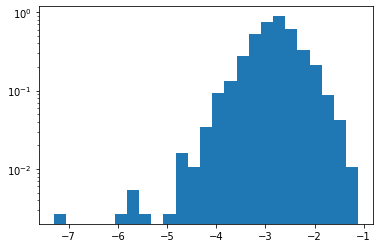

In [48]:
import matplotlib.pyplot as plt

with open('low_z_observed_stars.json','r') as f:
    lowz = json.load(f)
feh = []
for i in range(len(lowz['data'])):
    if type(lowz['data'][i]['Fe/H']) == str:
        app = float(lowz['data'][i]['Fe/H'][1:])
    else:
        app = float(lowz['data'][i]['Fe/H'])
    feh.append(app)
fig, ax = plt.subplots()
ax.hist(feh, bins=25, density=True)
ax.set_yscale('log')

In [45]:
feh


[-1.78,
 -2.93,
 -2.04,
 -2.98,
 -2.86,
 -3.08,
 -2.87,
 -2.63,
 -3.02,
 -2.92,
 -3.28,
 -2.34,
 -2.47,
 -1.11,
 -3.26,
 -3.06,
 -3.09,
 -2.72,
 -2.55,
 -2.7,
 -2.79,
 -3.33,
 -2.78,
 -2.29,
 -2.57,
 -2.52,
 -3.82,
 -3.24,
 -3.0,
 -3.08,
 -3.23,
 -2.49,
 -2.62,
 -2.92,
 -2.27,
 -2.94,
 -2.69,
 -2.21,
 -2.71,
 -2.06,
 -2.06,
 -2.72,
 -2.81,
 -2.68,
 -2.81,
 -3.08,
 -3.5,
 -3.47,
 -2.76,
 -2.31,
 -2.65,
 -2.5,
 -2.5,
 -2.42,
 -2.68,
 -2.46,
 -3.22,
 -2.91,
 -2.91,
 -2.56,
 -3.28,
 -3.61,
 -1.77,
 -2.4,
 -3.68,
 -2.44,
 -2.41,
 -2.88,
 -2.0,
 -2.0,
 -2.47,
 -3.22,
 -2.03,
 -2.31,
 -2.34,
 -3.81,
 -2.85,
 -2.8,
 -2.76,
 -3.17,
 -2.92,
 -2.85,
 -2.79,
 -3.13,
 -2.93,
 -3.08,
 -3.28,
 -3.31,
 -3.3,
 -2.55,
 -2.55,
 -2.56,
 -2.92,
 -2.71,
 -3.57,
 -2.35,
 -1.91,
 -2.52,
 -2.96,
 -2.99,
 -2.62,
 -2.97,
 -2.97,
 -2.65,
 -3.16,
 -3.01,
 -3.57,
 -3.12,
 -3.08,
 -2.68,
 -3.98,
 -3.98,
 -2.95,
 -2.62,
 -2.21,
 -2.36,
 -2.31,
 -2.13,
 -2.13,
 -3.46,
 -3.08,
 -3.4,
 -3.4,
 -2.85,
 -2.47,
 -3.03,
 -1.